In [107]:
# Import the necessary libraries first
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import chi2, r_regression
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM,Dropout, BatchNormalization, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.regularizers import L1L2

In [108]:
data=yf.download('0005.hk',"2017-09-28","2021-09-24")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-28,76.400002,77.099998,76.050003,76.199997,64.386993,22520013
2017-09-29,76.500000,76.900002,76.300003,76.550003,64.682732,16766252
2017-10-03,76.800003,77.449997,76.699997,77.449997,65.443207,24369212
2017-10-04,77.500000,77.949997,77.500000,77.849998,65.781197,21197563
2017-10-06,77.599998,77.800003,77.199997,77.349998,65.358711,23715110


In [109]:
data['Prediction']=data['Adj Close'].shift(-1)
data.drop('Adj Close',1,inplace=True)
data.head()

,Open,High,Low,Close,Volume,Prediction
Date,,,,,,
2017-09-28,76.400002,77.099998,76.050003,76.199997,22520013,64.682732
2017-09-29,76.500000,76.900002,76.300003,76.550003,16766252,65.443207
2017-10-03,76.800003,77.449997,76.699997,77.449997,24369212,65.781197
2017-10-04,77.500000,77.949997,77.500000,77.849998,21197563,65.358711
2017-10-06,77.599998,77.800003,77.199997,77.349998,23715110,65.485451


In [110]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MTM6']=talib.MOM(data['Close'],timeperiod=6)
data['MTM12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data.head()

,Open,High,Low,Close,Volume,Prediction,6day MA,12day MA,RSI,%R5,%R10,MTM6,MTM12,EMA12,EMA26,MACD,TR,OSC6,OSC12
Date,,,,,,,,,,,,,,,,,,,
2017-09-28,76.400002,77.099998,76.050003,76.199997,22520013,64.682732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-29,76.500000,76.900002,76.300003,76.550003,16766252,65.443207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.700005,NaN,NaN
2017-10-03,76.800003,77.449997,76.699997,77.449997,24369212,65.781197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.899994,NaN,NaN
2017-10-04,77.500000,77.949997,77.500000,77.849998,21197563,65.358711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN
2017-10-06,77.599998,77.800003,77.199997,77.349998,23715110,65.485451,NaN,NaN,NaN,-31.578969,NaN,NaN,NaN,NaN,NaN,NaN,0.650002,NaN,NaN


In [111]:
data.dropna(inplace=True)

In [112]:
# Feature extraction
X=data.drop('Prediction',1)
Y=data['Prediction'].values.reshape(-1,1)
test = SelectKBest(score_func=r_regression, k=5)
fit = test.fit(X, Y)

# Summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)

features = fit.transform(X)
# Summarize selected features
print(features[0:5,:])

[ 0.99   0.989  0.99   0.99  -0.326  0.988  0.986  0.123  0.091  0.145
  0.057  0.079  0.987  0.981  0.144 -0.122  0.118  0.139]
[[75.5   75.7   75.25  75.35  75.508]
 [75.35  75.65  75.1   75.25  75.408]
 [75.25  75.5   75.    75.1   75.267]
 [75.2   75.8   74.8   75.6   75.258]
 [75.5   78.1   75.45  76.95  75.558]]


/home/gordon/anaconda3/envs/FYP/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [9]:
#no of features
nof_list=np.arange(1,16)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 15
Score with 15 features: 0.980370


In [116]:
cols = list(X.columns)
model = RandomForestRegressor()
rfe = RFE(model,n_features_to_select=nof)
fit = rfe.fit(X, Y.ravel())
temp = pd.Series(fit.support_,index = cols)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Num Features: 15
Selected Features: [ True  True  True  True  True  True  True False  True False  True  True
  True  True  True  True False  True]
Feature Ranking: [1 1 1 1 1 1 1 4 1 3 1 1 1 1 1 1 2 1]
Index(['Open', 'High', 'Low', 'Close', 'Volume', '6day MA', '12day MA', '%R5',
       'MTM6', 'MTM12', 'EMA12', 'EMA26', 'MACD', 'TR', 'OSC12'],
      dtype='object')


In [130]:
def trim_dataset(mat, batch_size):
    
    #trims dataset to a size that's divisible by BATCH_SIZE
    no_of_rows_drop = mat.shape[0] % batch_size

    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat
    
def build_timeseries(mat, y_pred):
    
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]

    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))

    print("Length of inputs", dim_0)

    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = y_pred[TIME_STEPS+i,0]

    print("length of time-series - inputs", x.shape)
    print("length of time-series - outputs", y.shape)

    return x, y

train_cols = selected_features_rfe
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 10
}
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False,random_state=42)
print("Train--Test size", len(df_train), len(df_test))
min_max_scaler = MinMaxScaler()
min_max_scaler_y = MinMaxScaler()
x = df_train.loc[:,train_cols].values
y_train=df_train['Prediction'].values.reshape(-1,1)
y_train=min_max_scaler_y.fit_transform(y_train)
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])
y_test=df_test['Prediction'].values.reshape(-1,1)
y_test=min_max_scaler_y.fit_transform(y_test)
x_t, y_t = build_timeseries(x_train, y_train)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE).reshape(-1,1)
print(x_t)
print(y_t)
print("Batch trimmed size", x_t.shape, y_t.shape)

Train--Test size 759 190
Length of inputs 749
length of time-series - inputs (749, 10, 15)
length of time-series - outputs (749,)
[[[0.818 0.82  0.825 ... 0.497 0.09  0.469]
  [0.815 0.82  0.823 ... 0.497 0.079 0.454]
  [0.814 0.817 0.821 ... 0.497 0.067 0.432]
  ...
  [0.837 0.85  0.84  ... 0.566 0.247 0.671]
  [0.851 0.85  0.852 ... 0.58  0.09  0.688]
  [0.853 0.863 0.859 ... 0.606 0.225 0.789]]

 [[0.815 0.82  0.823 ... 0.497 0.079 0.454]
  [0.814 0.817 0.821 ... 0.497 0.067 0.432]
  [0.813 0.822 0.818 ... 0.504 0.18  0.531]
  ...
  [0.851 0.85  0.852 ... 0.58  0.09  0.688]
  [0.853 0.863 0.859 ... 0.606 0.225 0.789]
  [0.859 0.866 0.865 ... 0.627 0.124 0.789]]

 [[0.814 0.817 0.821 ... 0.497 0.067 0.432]
  [0.813 0.822 0.818 ... 0.504 0.18  0.531]
  [0.818 0.862 0.829 ... 0.53  0.551 0.716]
  ...
  [0.853 0.863 0.859 ... 0.606 0.225 0.789]
  [0.859 0.866 0.865 ... 0.627 0.124 0.789]
  [0.86  0.861 0.863 ... 0.641 0.09  0.77 ]]

 ...

 [[0.167 0.18  0.182 ... 0.902 0.348 0.846]
  [0

/home/gordon/anaconda3/envs/FYP/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [136]:
x_temp, y_temp = build_timeseries(x_test,y_test)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
print(x_test_t.shape)

Length of inputs 180
length of time-series - inputs (180, 10, 15)
length of time-series - outputs (180,)
(90, 10, 15)


In [144]:
# # Build the LSTM model
adam = Adam(lr=0.001)
reg=L1L2(l1=0.01, l2=0.01)
# BATCH_SIZE=1
# X=data_selected.drop('Prediction',1).values
# sc = MinMaxScaler(feature_range=(-1,1))
# sc_y = MinMaxScaler(feature_range=(-1,1))
# X=sc.fit_transform(X)
# X = X.reshape(X.shape[0], 1, X.shape[1])
# y=data_selected['Prediction'].values.reshape(-1,1)
# y=sc_y.fit_transform(y)
# print(y)
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
model = Sequential()
model.add(LSTM(128, batch_input_shape=(BATCH_SIZE,TIME_STEPS,nof),
                        dropout=0.0, recurrent_dropout=0.0,
                        stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform',
                        bias_regularizer=reg))
model.add(Dropout(0.4))

model.add(LSTM(64, dropout=0.0))
# model.add(Dropout(0.4))
    
model.add(Dense(32))
model.add(Dense(1))
# model.add(LSTM(7,input_shape=(1, X.shape[2]),bias_regularizer=reg,dropout=0.4,unit_forget_bias=False,return_sequences=True))
# model.add(Dense(1))
model.compile(
  loss="mean_squared_error",
  optimizer=adam
)

/home/gordon/anaconda3/envs/FYP/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:357: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [145]:
model.summary() 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (20, 10, 128)             73728     
_________________________________________________________________
dropout_19 (Dropout)         (20, 10, 128)             0         
_________________________________________________________________
lstm_21 (LSTM)               (20, 64)                  49408     
_________________________________________________________________
dense_20 (Dense)             (20, 32)                  2080      
_________________________________________________________________
dense_21 (Dense)             (20, 1)                   33        
Total params: 125,249
Trainable params: 125,249
Non-trainable params: 0
_________________________________________________________________


In [146]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history = model.fit(x_t,y_t,epochs=100,batch_size=BATCH_SIZE,validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)),shuffle=False, callbacks=[es])

Epoch 1/100
37/37 [==============================] - 3s 34ms/step - loss: 2.6371 - val_loss: 2.5079
Epoch 2/100
37/37 [==============================] - 0s 7ms/step - loss: 2.4656 - val_loss: 2.3370
Epoch 3/100
37/37 [==============================] - 0s 7ms/step - loss: 2.2730 - val_loss: 2.2034
Epoch 4/100
37/37 [==============================] - 0s 7ms/step - loss: 2.1291 - val_loss: 2.0868
Epoch 5/100
37/37 [==============================] - 0s 7ms/step - loss: 2.0085 - val_loss: 1.9707
Epoch 6/100
37/37 [==============================] - 0s 7ms/step - loss: 1.8917 - val_loss: 1.8568
Epoch 7/100
37/37 [==============================] - 0s 7ms/step - loss: 1.7781 - val_loss: 1.7429
Epoch 8/100
37/37 [==============================] - 0s 7ms/step - loss: 1.6669 - val_loss: 1.6383
Epoch 9/100
37/37 [==============================] - 0s 7ms/step - loss: 1.5622 - val_loss: 1.5381
Epoch 10/100
37/37 [==============================] - 0s 7ms/step - loss: 1.4624 - val_loss: 1.4384
Epoch 11

In [147]:
y_pred = model.predict(trim_dataset(x_test_t,BATCH_SIZE),batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)

# convert the predicted value to range of real data
y_pred_org = min_max_scaler_y.inverse_transform(y_pred.reshape(-1,1))
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org =min_max_scaler_y.inverse_transform(y_test_t.reshape(-1,1))
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org)
print(y_test_t_org)

Error is 0.0741617379110697 (80,) (80,)
[[42.47 ]
 [42.696]
 [42.805]
 [43.038]
 [42.85 ]
 [42.792]
 [42.908]
 [43.091]
 [43.055]
 [42.927]
 [43.06 ]
 [42.85 ]
 [42.893]
 [42.829]
 [42.661]
 [42.526]
 [42.634]
 [42.738]
 [42.594]
 [42.399]
 [42.334]
 [42.251]
 [42.438]
 [42.635]
 [42.288]
 [41.91 ]
 [41.941]
 [41.933]
 [41.959]
 [42.121]
 [42.047]
 [41.749]
 [41.567]
 [41.527]
 [41.581]
 [41.744]
 [41.544]
 [41.294]
 [41.156]
 [41.159]
 [41.372]
 [41.401]
 [41.375]
 [41.163]
 [40.958]
 [40.823]
 [40.855]
 [41.097]
 [41.234]
 [41.036]
 [40.905]
 [40.789]
 [40.898]
 [41.009]
 [40.971]
 [40.934]
 [41.004]
 [41.048]
 [41.045]
 [41.208]
 [41.309]
 [41.47 ]
 [41.615]
 [41.633]
 [41.749]
 [41.497]
 [41.326]
 [41.111]
 [41.026]
 [41.084]
 [40.941]
 [41.038]
 [41.181]
 [41.161]
 [40.983]
 [40.835]
 [40.931]
 [40.814]
 [40.808]
 [40.834]]
[[47.94 ]
 [48.582]
 [47.841]
 [47.94 ]
 [48.286]
 [48.582]
 [48.483]
 [48.335]
 [50.162]
 [48.681]
 [49.125]
 [48.533]
 [48.187]
 [47.94 ]
 [48.088]
 [48.286]

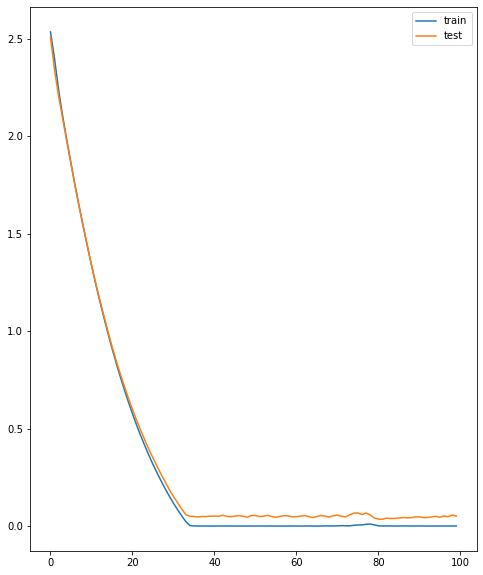

In [148]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

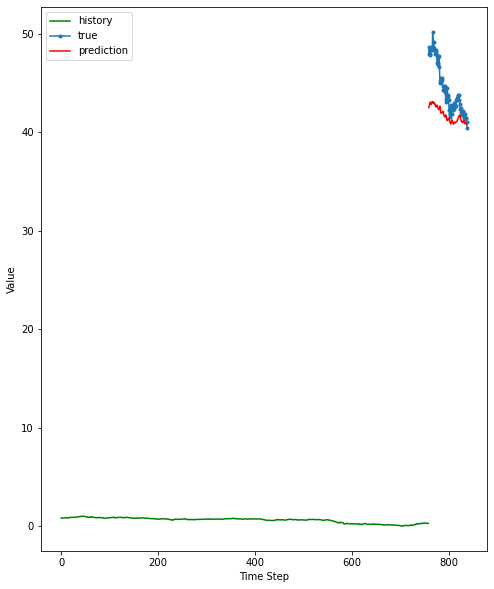

In [149]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_t)), y_test_t_org, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_t)), y_pred_org, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

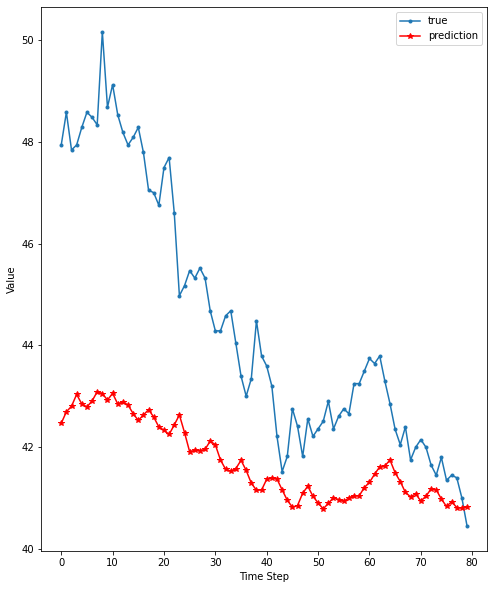

In [150]:
plt.plot(y_test_t_org, marker='.', label="true")
plt.plot(y_pred_org, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [151]:
from sklearn.metrics import r2_score
r2_score(y_test_t_org,y_pred_org)

-0.6842003566227184

In [142]:
#model.save('HSBC_FeatureSelected')

In [152]:
x_unseen.shape

(20, 10, 5)

In [143]:
y_unseen=data_unseen['Prediction'].values.reshape(-1,1)
y_unseen_pred=model.predict(x_unseen,batch_size=20)
y_unseen_pred=min_max_scaler_y.inverse_transform(y_unseen_pred)

InvalidArgumentError:    Specified a list with shape [20,15] from a tensor with shape [20,5]
	 [[{{node TensorArrayUnstack/TensorListFromTensor}}]]
	 [[sequential_9/lstm_18/PartitionedCall]] [Op:__inference_predict_function_84172]

Function call stack:
predict_function -> predict_function -> predict_function


In [ ]:
plt.plot(y_unseen, marker='.', label="true")
plt.plot(y_unseen_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
r2_score(data_unseen['Prediction'].values,unseen_pred)